In [1]:
import pandas as pd
import pathlib
import pandas_profiling
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
test_path, train_path = sorted(list(pathlib.Path.cwd().rglob('./heart*.csv')))

In [3]:
train_pd, test_pd = pd.read_csv(train_path), pd.read_csv(test_path)

In [4]:
overall_pd = pd.concat((train_pd, test_pd)).reset_index().drop(['index'], axis=1)

In [5]:
print(overall_pd.shape)

(303, 14)


In [6]:
overall_pd.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,69,0,3,140,239,0,1,151,0,1.8,2,2,2,1
1,66,1,1,160,246,0,1,120,1,0.0,1,3,1,0
2,55,0,0,128,205,0,2,130,1,2.0,1,1,3,0
3,57,1,0,110,335,0,1,143,1,3.0,1,1,3,0
4,71,0,2,110,265,1,0,130,0,0.0,2,1,2,1


In [9]:
def is_boolean(column):
    return set(column.unique()) == {0, 1}

In [10]:
def is_categorical(column, cardinality_tshresh=5):
    return column.nunique()<cardinality_tshresh and not is_boolean(column)

In [11]:
def is_numeric(column):
    is_num = np.issubdtype(column.dtype, np.number)
    
    return (is_num and not is_boolean(column) and not is_categorical(column))

In [12]:
all_columns = overall_pd.columns.values

In [13]:
numerical_columns = all_columns[np.array([is_numeric(overall_pd[column]) for column in overall_pd.columns])]
bool_columns = all_columns[np.array([is_boolean(overall_pd[column]) for column in overall_pd.columns])]
categorical_columns = all_columns[np.array([is_categorical(overall_pd[column]) for column in overall_pd.columns])]

In [14]:
print(f"Numerical columns {numerical_columns}")
print(f"Boolean columns {bool_columns}")
print(f"Categorical columns {categorical_columns}")

Numerical columns ['age' 'trestbps' 'chol' 'thalach' 'oldpeak' 'ca']
Boolean columns ['sex' 'fbs' 'exang' 'target']
Categorical columns ['cp' 'restecg' 'slope' 'thal']


Numerical values distribution


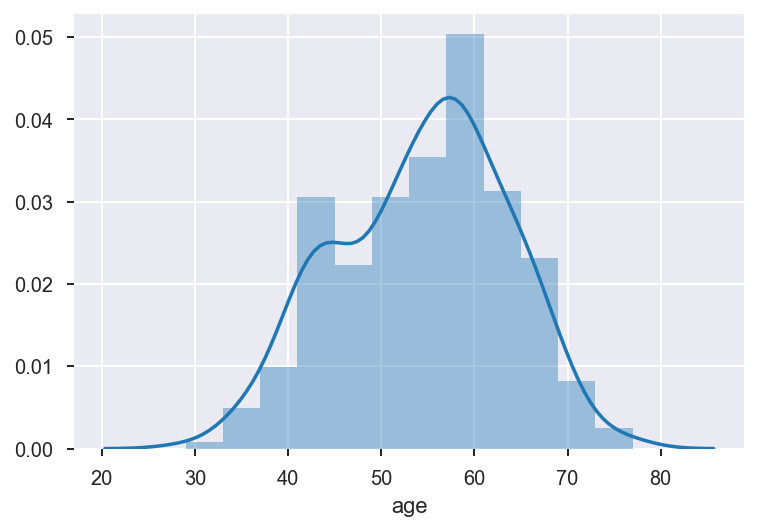

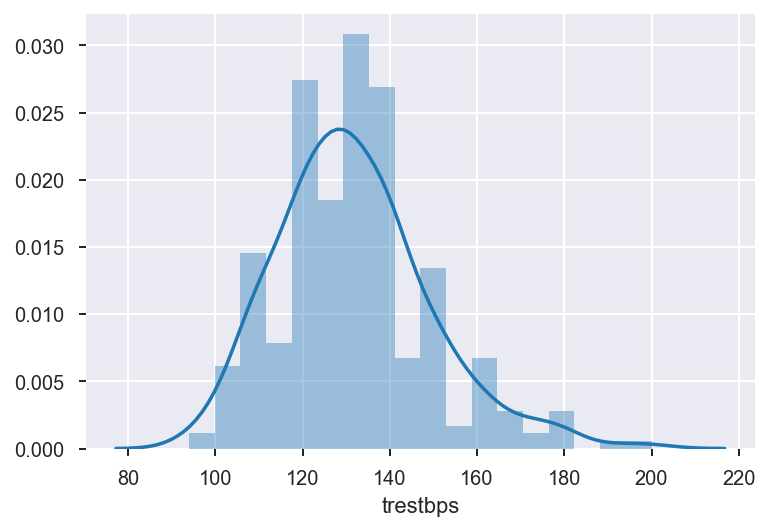

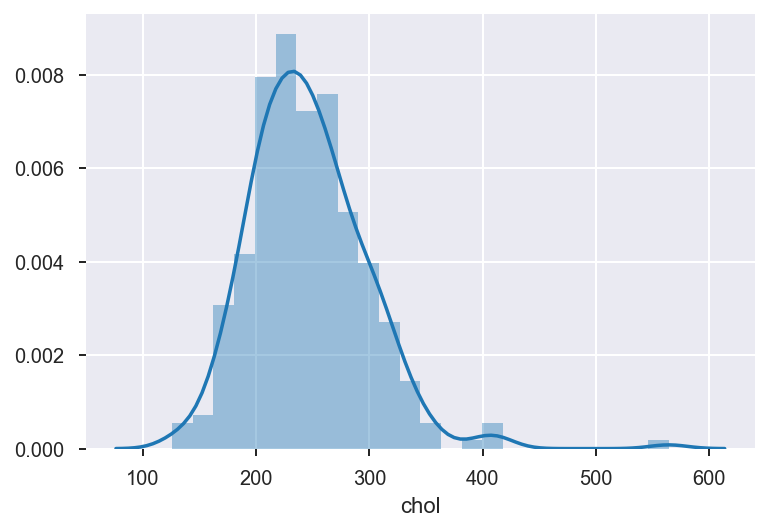

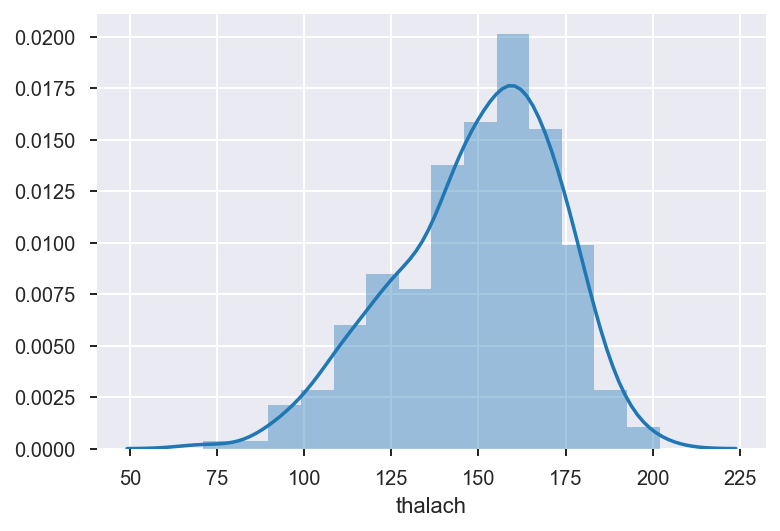

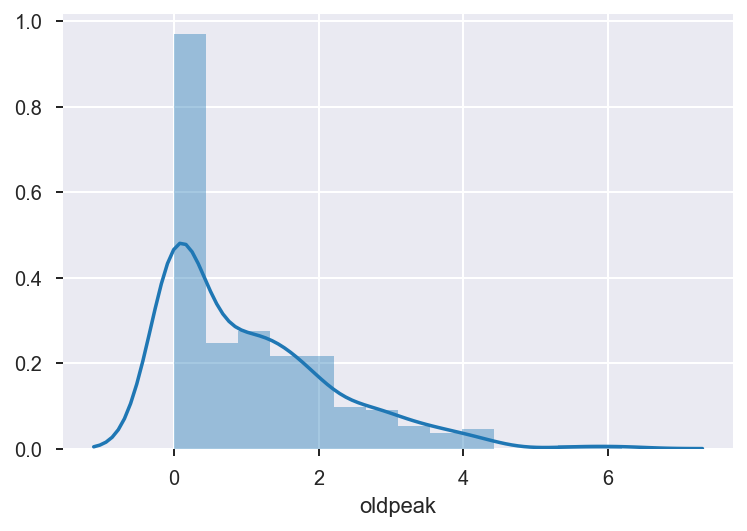

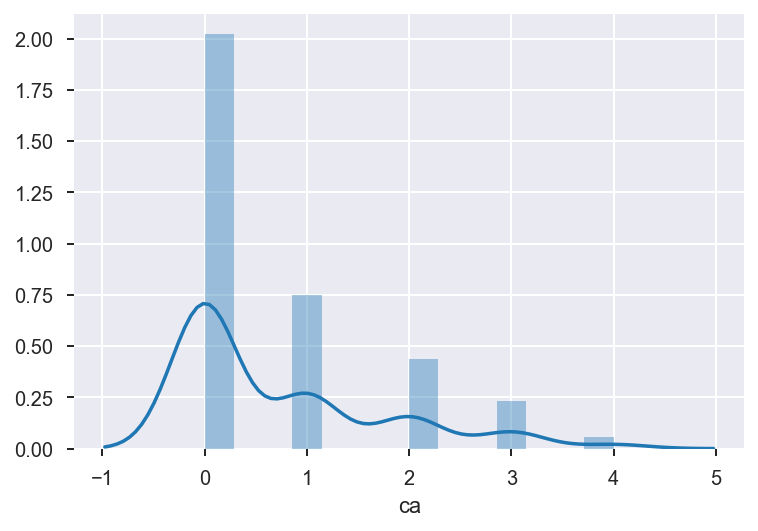

In [103]:
print("Numerical values distribution")
for column in numerical_columns:
    sns.distplot(overall_pd[column])
    plt.show()

Boolean values distribution


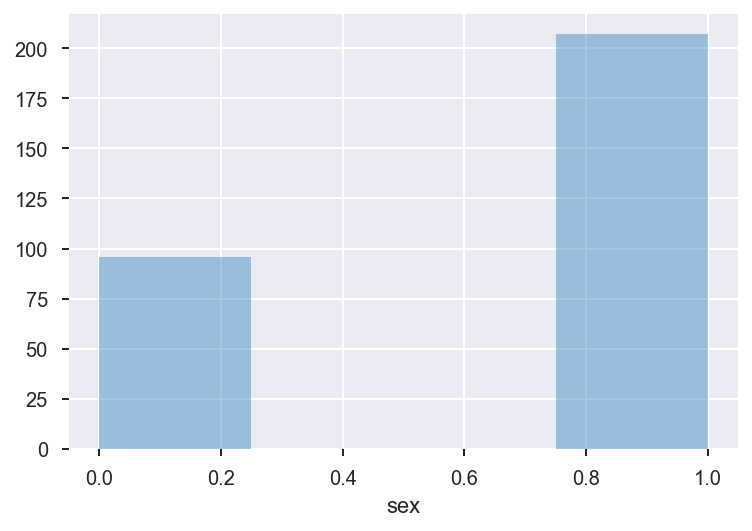

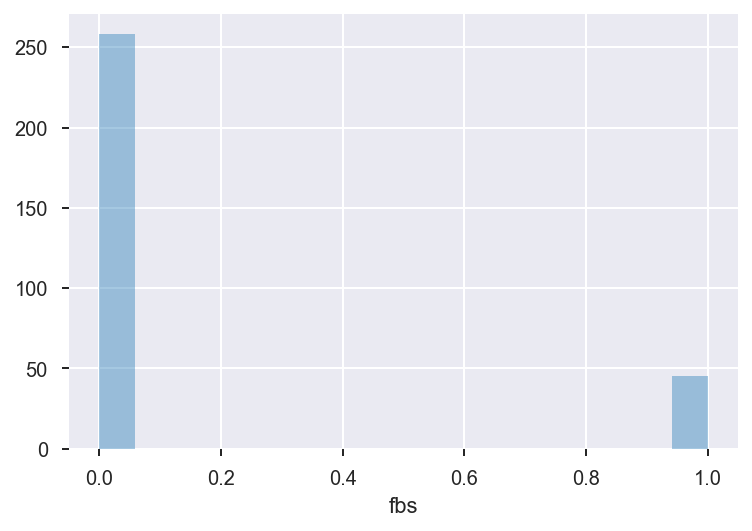

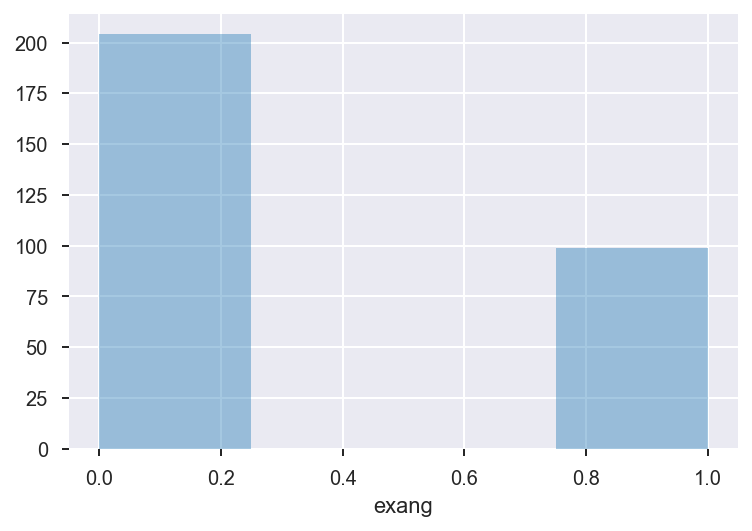

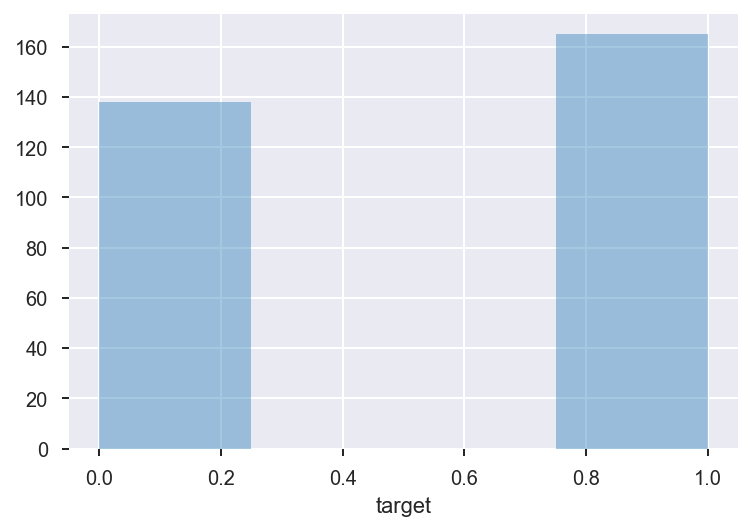

In [104]:
print("Boolean values distribution")
for column in bool_columns:
    sns.distplot(overall_pd[column], kde=False)
    plt.show()

Categorical values distribution


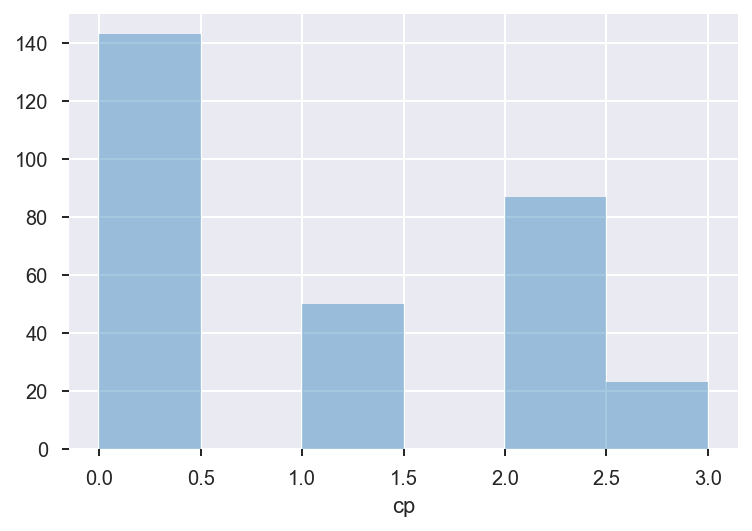

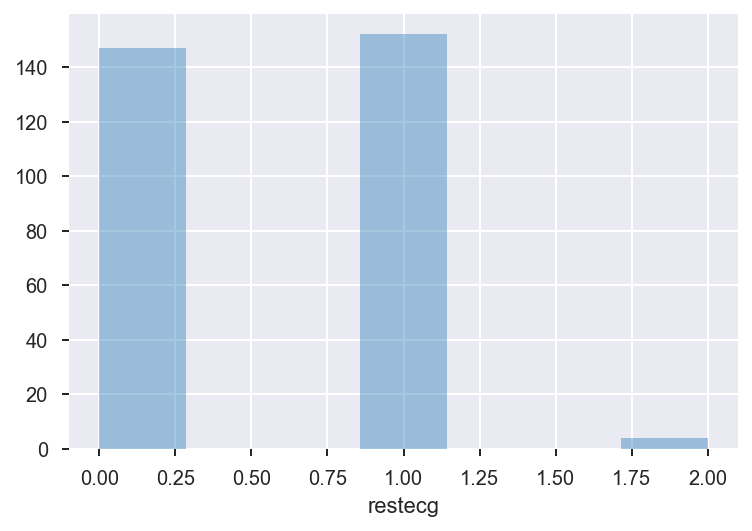

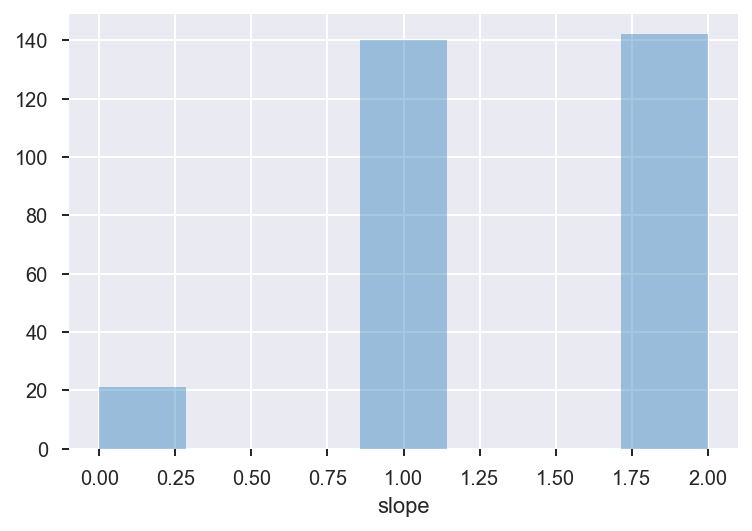

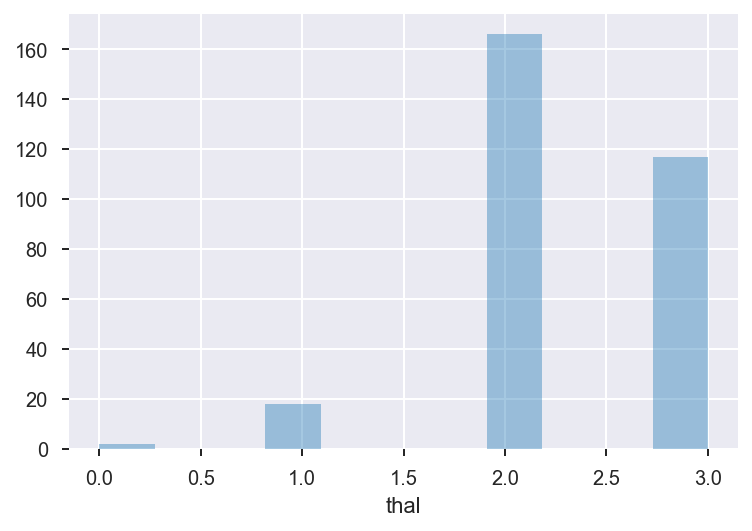

In [105]:
print("Categorical values distribution")
for column in categorical_columns:
    sns.distplot(overall_pd[column], kde=False)
    plt.show()

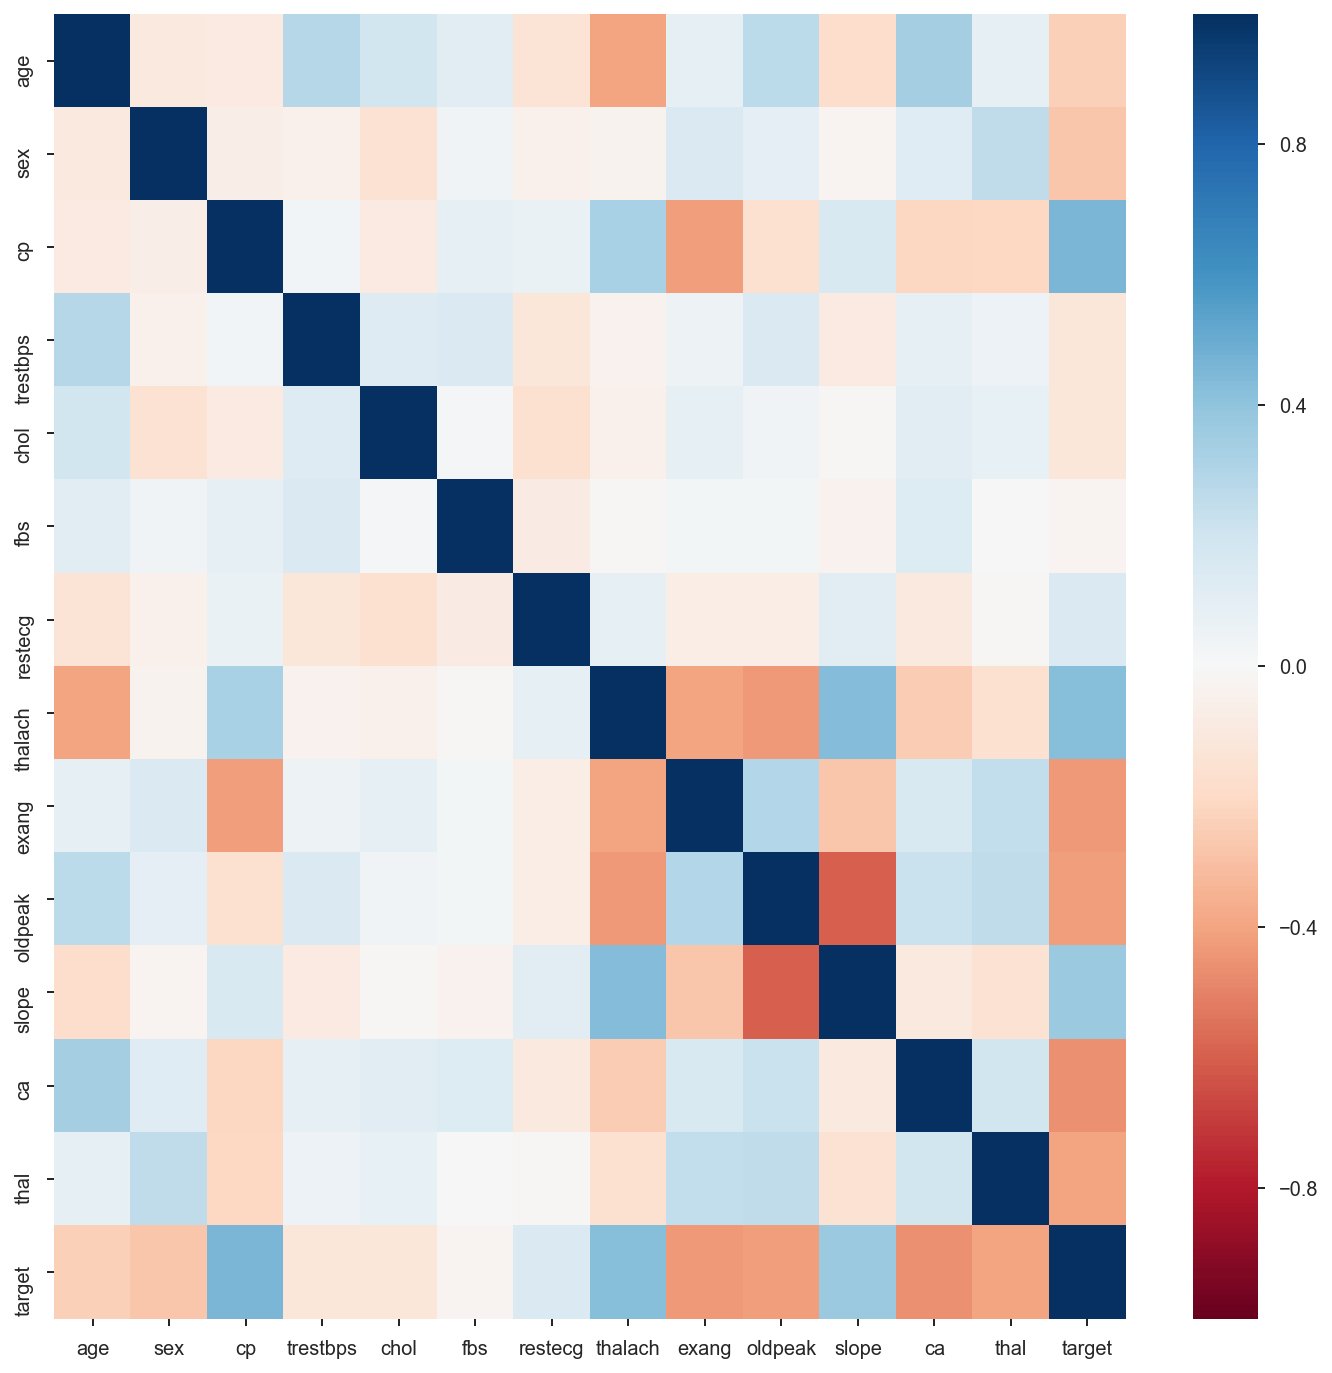

In [16]:
plt.subplots(figsize=(12, 12))

cmap = sns.color_palette("RdBu", n_colors=1000)

sns.heatmap(overall_pd.corr(method='spearman'), vmin=-1, vmax=1, cmap=cmap)

In [128]:
encoded = pd.get_dummies(overall_pd,columns=categorical_columns)

In [131]:
scaler = StandardScaler()
scaled_numerical_cols = scaler.fit_transform(encoded[numerical_columns])

In [132]:
encoded[numerical_columns] = scaled_numerical_cols

In [137]:
encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,...,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,1.613930,0,0.478391,-0.140381,0,0.059173,0,0.655990,1.244593,1,...,0,1,0,0,0,1,0,0,1,0
1,1.283063,1,1.620649,-0.005102,0,-1.296472,1,-0.896862,2.224104,0,...,0,1,0,0,1,0,0,1,0,0
2,0.069886,0,-0.206964,-0.797447,0,-0.859167,1,0.828529,0.265082,0,...,0,0,1,0,1,0,0,0,0,1
3,0.290464,1,-1.234996,1.714865,0,-0.290671,1,1.691225,0.265082,0,...,0,1,0,0,1,0,0,0,0,1
4,1.834507,0,-1.234996,0.362082,1,-0.859167,0,-0.896862,0.265082,1,...,1,0,0,0,0,1,0,0,1,0


In [50]:
pandas_profiling.ProfileReport(overall_pd)

### `target` column is negatively correlated with `cp, slope, thalac` features and positively correlated with
### `exang,` `old_peak`, `ca`. I would definetely use those columns as features for linear models. 

### (Assuredly correlation shouldn't be the single criterion for feature selection , I'd delegate this to 

### `SelectFromModel` method from sklearn most probably)